In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


In [2]:
# Read in the data for the upper and lower ice surfaces and the bed

zs = pd.read_table("../Data/ElmerOutput/ZsOut", delimiter=" ")
zb = pd.read_table("../Data/ElmerOutput/ZbOut", delimiter=" ")
bed = pd.read_table("../Data/ElmerOutput/Bedrock", delimiter=" ")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_7565/3681978309.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS)


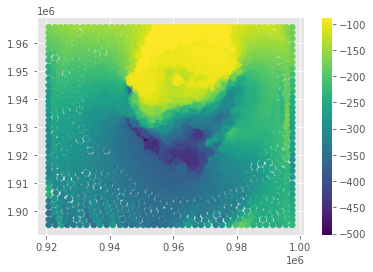

In [3]:
# Plot the lower surface

fig, ax = plt.subplots(1, 1)
CS = ax.scatter(zb["X"], zb["Y"], c=zb["Z"]) 
fig.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_7565/1956625637.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS)


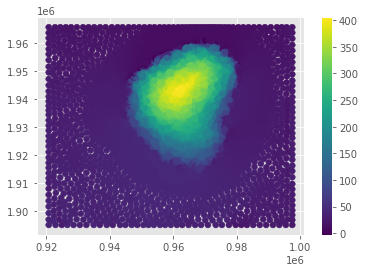

In [4]:
# Plot the upper surface

fig, ax = plt.subplots(1, 1)
CS = ax.scatter(zs["X"], zs["Y"], c=zs["Z"]) 
fig.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_7565/2470845732.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS)


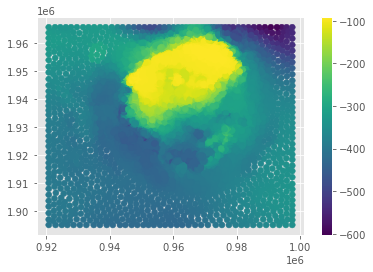

In [5]:
# Plot the bed

fig, ax = plt.subplots(1, 1)
CS = ax.scatter(bed["X"], bed["Y"], c=bed["Z"]) 
fig.colorbar(CS)


## Steps

- Convert zb, zs and bedrock into netcdf files (prefereably one, otherwise convert using gmt)
- Will need to define a mesh grid and interpolate the unstructured data onto the structured grid
- Find previous examples, e.g. the SMB conversion scripts

In [6]:
# Find min and max coords

x_min = min(zs["X"])
y_min = min(zs["Y"])
x_max = max(zs["X"])
y_max = max(zs["Y"])
nxy = 10000

# Define structured domain

x = np.linspace(x_min, x_max, nxy)
y = np.linspace(y_min, y_max, nxy)
grid_x, grid_y = np.mgrid[x_min:x_max:10000j, y_min:y_max:10000j]


In [7]:
# Interpolate the upper surface data

zs_int = scipy.interpolate.griddata((zs["X"], zs["Y"]), zs["Z"], (grid_x, grid_y), method='linear')


In [8]:
# Interpolate the lower surface data

zb_int = scipy.interpolate.griddata((zb["X"], zb["Y"]), zb["Z"], (grid_x, grid_y), method='linear')


In [9]:
# Interpolate the bed data

bed_int = scipy.interpolate.griddata((bed["X"], bed["Y"]), bed["Z"], (grid_x, grid_y), method='linear')


In [10]:
# Convert the datasets to netcdf files

zs_int_T = zs_int.transpose()
zb_int_T = zb_int.transpose()
bed_int_T = bed_int.transpose()

d_zs = xr.DataArray(
    data=zs_int_T,
    dims=['y', 'x'],
    coords=dict(
        x=grid_x[:,0],
        y=grid_y[0,:]
    )
)

d_zb = xr.DataArray(
    data=zb_int_T,
    dims=['y', 'x'],
    coords=dict(
        x=grid_x[:,0],
        y=grid_y[0,:]
    )
)

d_bed = xr.DataArray(
    data=bed_int_T,
    dims=['y', 'x'],
    coords=dict(
        x=grid_x[:,0],
        y=grid_y[0,:]
    )
)

d_zs.to_netcdf('../Data/ElmerInput/zs.nc')
d_zb.to_netcdf('../Data/ElmerInput/zb.nc')
d_bed.to_netcdf('../Data/ElmerInput/bed.nc')
